In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR

For detailed comments about the code look at the first quarter analysis

# Third quarter

First all the products are aggregated per category, taking as price of the category the mean of the log(price_changes) 

In [4]:
pdthird = pd.read_csv('dataset/third_quarter.csv', index_col=0)

In [5]:
pdthird

,comp_date,seller_id,seller_name,product_id,price,min(price),max(price),coded_cat1,coded_cat2,coded_cat3,coded_brand,price_change,price_change_log,price_change_var
375,2021-07-01,23,C,112513,26999,19138,28990,1163,849,1164,316,NaN,NaN,10792.098901
513,2021-07-01,23,C,125297,4999,3999,4999,1354,1600,1262,370,NaN,NaN,263.157895
606,2021-07-01,23,C,127804,11699,9148,15890,1163,849,1258,537,NaN,NaN,92906.398046
685,2021-07-01,23,C,130178,3999,2389,3999,1127,1684,1830,418,NaN,NaN,2638.363858
911,2021-07-01,23,C,134922,2789,2299,3439,1354,1600,1262,502,NaN,NaN,668.518519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2153205,2021-09-30,490,L,165843,32299,32299,39999,2880,498,1732,289,0.0,0.0,357032.967033
2153206,2021-09-30,490,L,165844,37399,36264,43999,2880,498,1732,289,0.0,0.0,698520.146520
2153208,2021-09-30,490,L,165924,29499,25074,31499,1676,2218,2397,289,0.0,0.0,93023.255814
2153209,2021-09-30,490,L,165956,43990,37990,48990,1676,2193,2409,522,0.0,0.0,892857.142857


In [6]:
ge=pdthird.groupby(['comp_date','seller_id','coded_cat1'])['price_change_log'].mean().reset_index()
ge['comp_date'] = pd.to_datetime(ge['comp_date'])

pivot={}
for i in pdthird['coded_cat1'].unique():
    pivot[i] = ge[ge['coded_cat1']==i].pivot(index='comp_date', columns='seller_id', values='price_change_log')

for i in pdthird['coded_cat1'].unique():
    globals()['pivot{}'.format(i)] = pivot[i]

Dropping all the seller that have all null values for a specific category

In [7]:
c=0
for i in pdthird['coded_cat1'].unique():
    for j in globals()['pivot{}'.format(i)].columns:
        if np.isnan(globals()['pivot{}'.format(i)][j]).all() == True or (globals()['pivot{}'.format(i)][j]).sum() == 0:
            print(f'for the seller {j} the category {i} has all null values or zeros, so we drop it')
            globals()['pivot{}'.format(i)].drop(j, inplace=True, axis=1)
        else:
            c += 1

if c == 100:
    print('None of the category has all null values for each of sellers')

None of the category has all null values for each of sellers


In [9]:
#fill na in all the pivot
for i in pdthird['coded_cat1'].unique():
    globals()['pivot{}'.format(i)] = globals()['pivot{}'.format(i)].fillna(method='ffill')
    globals()['pivot{}'.format(i)] = globals()['pivot{}'.format(i)].fillna(method='bfill')
    globals()['pivot{}'.format(i)] = globals()['pivot{}'.format(i)].fillna(0)

## Pivot 1163

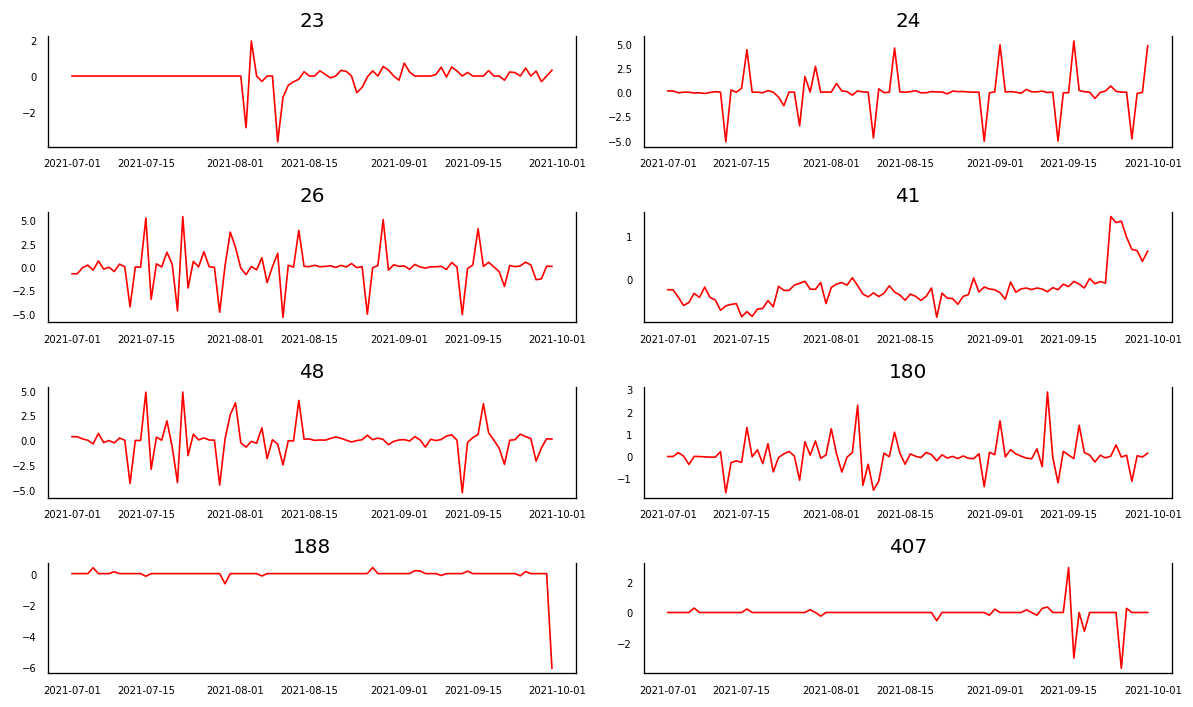

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1163[pivot1163.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(pivot1163.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [11]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [12]:
for name, column in pivot1163.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1312
 No. Lags Chosen       = 5
 Critical value 1%     = -3.509
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0243. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.0386
 No. Lags Chosen       = 12
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 T

In [13]:
pivot1163 = pivot1163.diff().dropna()

In [14]:
for name, column in pivot1163.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.2337
 No. Lags Chosen       = 5
 Critical value 1%     = -3.51
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.2898
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [15]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [16]:
cointegration_test(pivot1163)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  451.4     > 179.5199  =>   True
24     ::  351.26    > 143.6691  =>   True
26     ::  270.01    > 111.7797  =>   True
41     ::  199.29    > 83.9383   =>   True
48     ::  136.94    > 60.0627   =>   True
180    ::  77.47     > 40.1749   =>   True
188    ::  44.43     > 24.2761   =>   True
407    ::  16.01     > 12.3212   =>   True
490    ::  0.01      > 4.1296    =>   False


In [17]:
#VAR model on df_pivot
model = VAR(pivot1163)
x = model.select_order(maxlags=8)
x.summary()

c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-0.1767,0.08562,0.8381,-0.07129
1,-1.790,0.8333,0.1688,-0.7358
2,-2.354,2.630,0.1023,-0.3517
3,-2.810,4.534,0.07715,0.1409
4,-4.178,5.526,0.02808,-0.2796
5,-5.423,6.642,0.01562,-0.5761
6,-6.676,7.749,0.01429,-0.8808
7,-11.38,5.410,0.001069,-4.632
8,-20.46*,-1.313*,9.483e-06*,-12.77*


In [18]:
model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:08:01
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -1.31335
Nobs:                     83.0000    HQIC:                  -12.7680
Log likelihood:           446.146    FPE:                9.48346e-06
AIC:                     -20.4601    Det(Omega_mle):     3.24002e-08
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.066171         0.065825            1.005           0.315
L1.23         -0.313520         0.269863           -1.162           0.245
L1.24          0.078283         0.136642            0.573           0.567
L1.26          0.

# PIVOT 1375

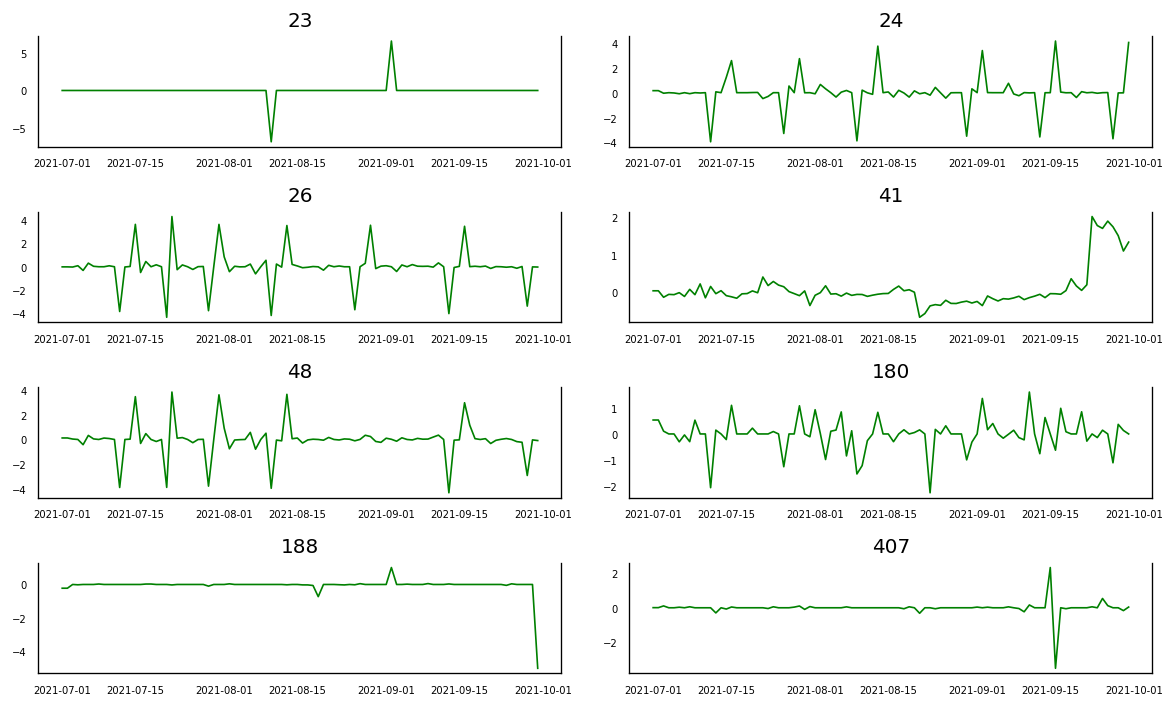

In [19]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1375[pivot1375.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1375.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [20]:
    
for name, column in pivot1375.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.4341
 No. Lags Chosen       = 0
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.458
 No. Lags Chosen       = 12
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [21]:
pivot1375 = pivot1375.diff().dropna()

In [22]:
    
for name, column in pivot1375.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.9282
 No. Lags Chosen       = 4
 Critical value 1%     = -3.509
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.5953
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [23]:
cointegration_test(pivot1375)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  535.45    > 179.5199  =>   True
24     ::  398.62    > 143.6691  =>   True
26     ::  284.01    > 111.7797  =>   True
41     ::  189.54    > 83.9383   =>   True
48     ::  132.74    > 60.0627   =>   True
180    ::  85.01     > 40.1749   =>   True
188    ::  51.48     > 24.2761   =>   True
407    ::  25.5      > 12.3212   =>   True
490    ::  6.56      > 4.1296    =>   True


In [24]:

#VAR model on df_pivot
model = VAR(pivot1375)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-3.003,-2.741,0.04963,-2.898
1,-4.062,-1.439,0.01739,-3.009
2,-4.176,0.8078,0.01655,-2.174
3,-4.394,2.950,0.01582,-1.444
4,-4.877,4.828,0.01397,-0.9779
5,-4.944,7.121,0.02523,-0.09668
6,-7.357,7.069,0.007234,-1.561
7,-12.15,4.639,0.0004940,-5.404
8,-26.16*,-7.012*,3.177e-08*,-18.47*


In [25]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:08:07
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -7.01222
Nobs:                     83.0000    HQIC:                  -18.4669
Log likelihood:           682.649    FPE:                3.17672e-08
AIC:                     -26.1589    Det(Omega_mle):     1.08533e-10
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.004585         0.127624           -0.036           0.971
L1.23         -0.772248         0.349014           -2.213           0.027
L1.24          0.160806         0.299257            0.537           0.591
L1.26          1.

# PIVOT 2180

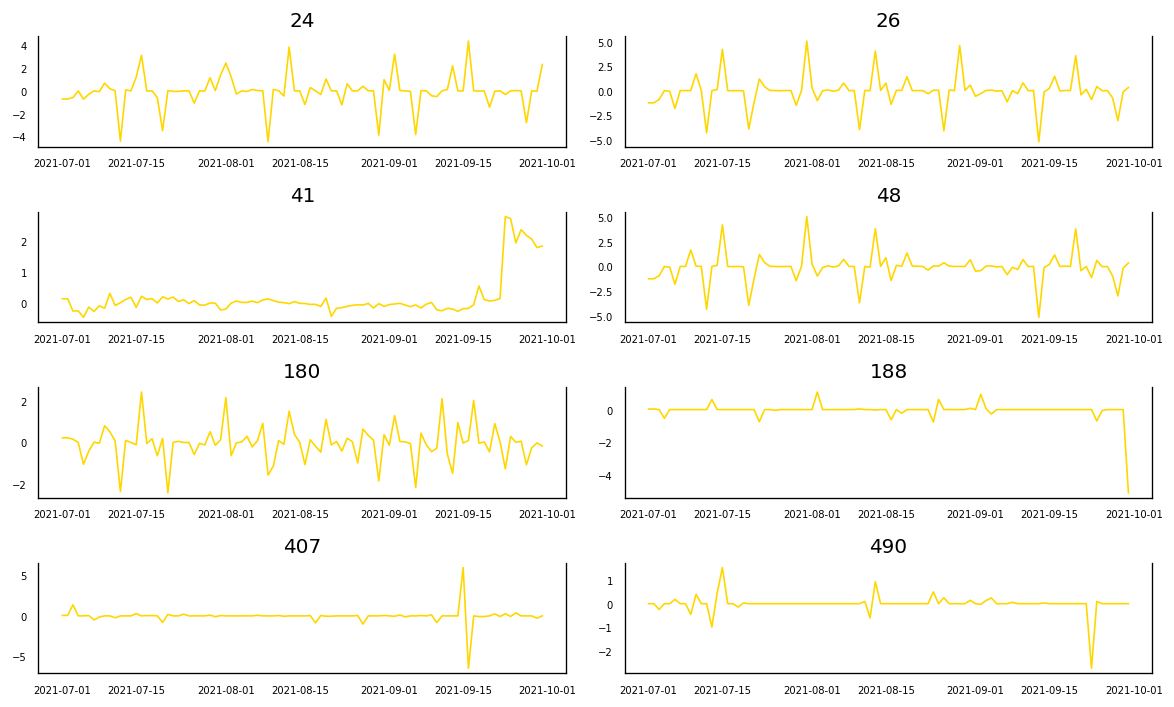

In [26]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot2180[pivot2180.columns[i]]
    ax.plot(data, color='gold', linewidth=1)
    # Decorations
    ax.set_title(pivot2180.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [27]:
for name, column in pivot2180.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.7582
 No. Lags Chosen       = 3
 Critical value 1%     = -3.507
 Critical value 5%     = -2.895
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.3703
 No. Lags Chosen       = 2
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [28]:
pivot2180 = pivot2180.diff().dropna()

In [29]:
for name, column in pivot2180.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.4476
 No. Lags Chosen       = 5
 Critical value 1%     = -3.51
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.729
 No. Lags Chosen       = 6
 Critical value 1%     = -3.511
 Critical value 5%     = -2.897
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test St

In [30]:
cointegration_test(pivot2180)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  479.05    > 143.6691  =>   True
26     ::  342.47    > 111.7797  =>   True
41     ::  242.61    > 83.9383   =>   True
48     ::  160.91    > 60.0627   =>   True
180    ::  104.3     > 40.1749   =>   True
188    ::  64.23     > 24.2761   =>   True
407    ::  32.31     > 12.3212   =>   True
490    ::  11.54     > 4.1296    =>   True


In [31]:

#VAR model on df_pivot
model = VAR(pivot2180)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-0.08368,0.1495,0.9197,0.009984
1,-1.996,0.1023*,0.1368,-1.153
2,-2.540,1.423,0.08263,-0.9481
3,-3.225,2.604,0.04640,-0.8832
4,-3.913,3.781,0.02896,-0.8222
5,-4.161,5.398,0.03324,-0.3211
6,-6.374,5.050,0.006952,-1.785
7,-8.323,4.967,0.002903,-2.984
8,-11.05*,4.108,0.001205*,-4.958*


In [32]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:08:14
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.10797
Nobs:                     83.0000    HQIC:                  -4.95811
Log likelihood:           36.2425    FPE:                 0.00120460
AIC:                     -11.0462    Det(Omega_mle):     1.17862e-05
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.042873         0.192028            0.223           0.823
L1.24         -0.706180         0.321442           -2.197           0.028
L1.26          0.050306         0.520294            0.097           0.923
L1.41         -2.

# PIVOT 1676

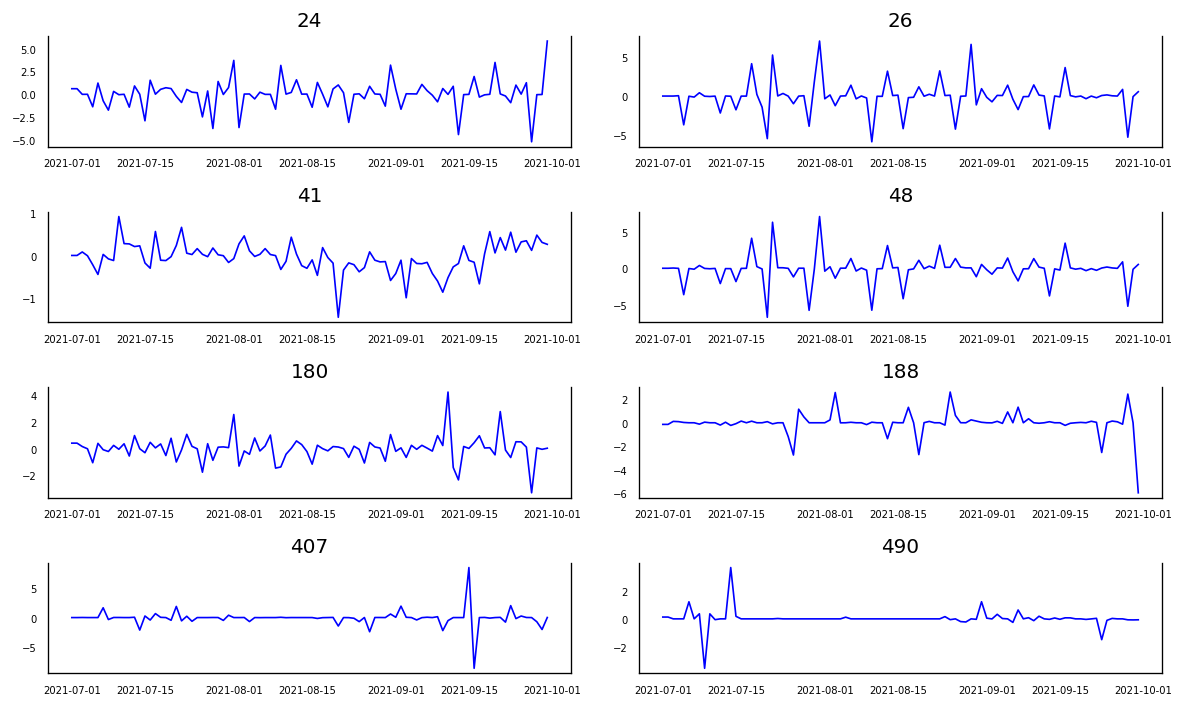

In [33]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1676[pivot1676.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(pivot1676.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [34]:
for name, column in pivot1676.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.4994
 No. Lags Chosen       = 2
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.8396
 No. Lags Chosen       = 2
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [35]:
pivot1676 = pivot1676.diff().dropna()

In [36]:
for name, column in pivot1676.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.5981
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.9501
 No. Lags Chosen       = 7
 Critical value 1%     = -3.512
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [37]:
cointegration_test(pivot1676)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  415.15    > 143.6691  =>   True
26     ::  319.95    > 111.7797  =>   True
41     ::  243.31    > 83.9383   =>   True
48     ::  175.56    > 60.0627   =>   True
180    ::  114.46    > 40.1749   =>   True
188    ::  63.96     > 24.2761   =>   True
407    ::  37.67     > 12.3212   =>   True
490    ::  16.47     > 4.1296    =>   True


In [38]:

#VAR model on df_pivot
model = VAR(pivot1676)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,4.976,5.209*,144.9,5.070
1,3.286,5.385,26.93,4.129
2,2.709,6.672,15.73,4.301
3,2.104,7.932,9.563,4.445
4,1.917,9.611,9.858,5.008
5,1.635,11.19,10.94,5.475
6,0.4642,11.89,6.488,5.054
7,-0.9749,12.31,4.507*,4.364
8,-2.545*,12.61,5.926,3.543*


In [39]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:08:21
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    12.6090
Nobs:                     83.0000    HQIC:                   3.54293
Log likelihood:          -316.550    FPE:                    5.92646
AIC:                     -2.54518    Det(Omega_mle):       0.0579864
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.033433         0.153573            0.218           0.828
L1.24         -1.002250         0.224156           -4.471           0.000
L1.26         -0.573444         0.314352           -1.824           0.068
L1.41         -0.

 # PIVOT 2259

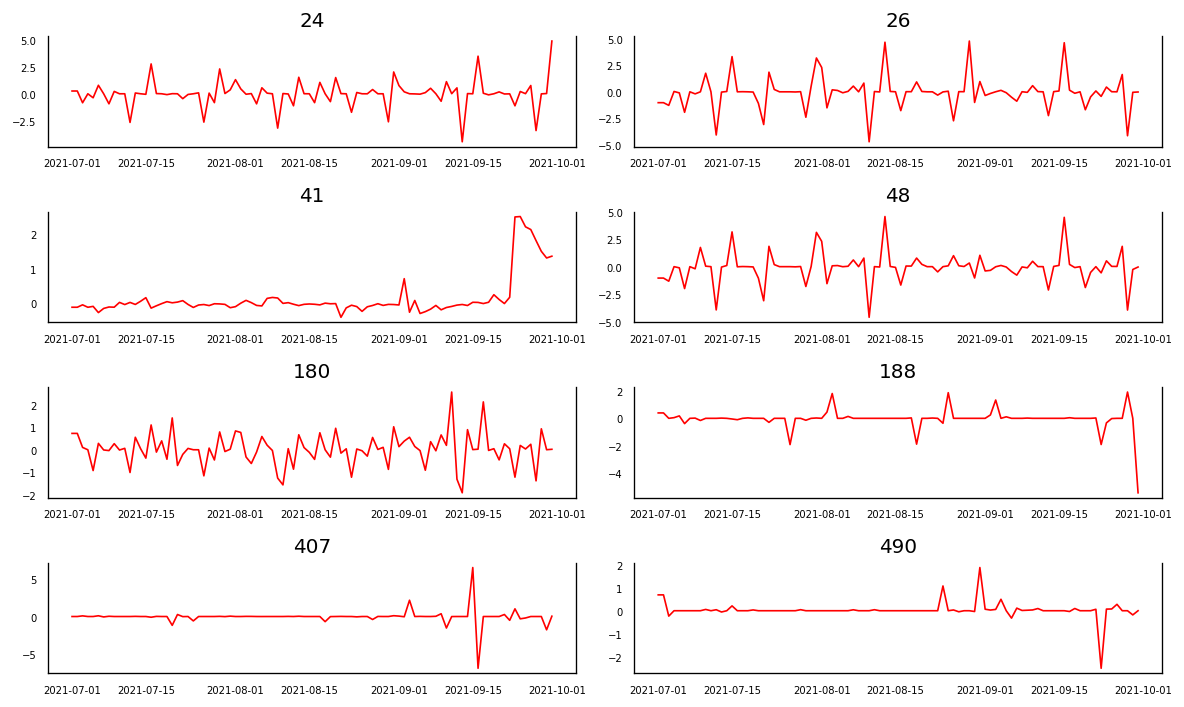

In [40]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot2259[pivot2259.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(pivot2259.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [41]:
 
for name, column in pivot2259.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.5265
 No. Lags Chosen       = 12
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.7039
 No. Lags Chosen       = 2
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [42]:
pivot2259 = pivot2259.diff().dropna()

In [43]:
 
for name, column in pivot2259.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.3035
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.9469
 No. Lags Chosen       = 6
 Critical value 1%     = -3.511
 Critical value 5%     = -2.897
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [44]:
cointegration_test(pivot2259)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  377.14    > 143.6691  =>   True
26     ::  281.58    > 111.7797  =>   True
41     ::  197.76    > 83.9383   =>   True
48     ::  131.98    > 60.0627   =>   True
180    ::  82.37     > 40.1749   =>   True
188    ::  46.87     > 24.2761   =>   True
407    ::  21.61     > 12.3212   =>   True
490    ::  8.05      > 4.1296    =>   True


In [45]:

#VAR model on df_pivot
model = VAR(pivot2259)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-0.3223,-0.08915*,0.7245,-0.2286
1,-2.163,-0.06500,0.1157,-1.320
2,-2.420,1.544,0.09322,-0.8275
3,-3.486,2.343,0.03573,-1.144
4,-4.402,3.292,0.01777,-1.311
5,-4.581,4.978,0.02184,-0.7410
6,-5.892,5.532,0.01126,-1.302
7,-7.543,5.746,0.006329,-2.204
8,-10.16*,4.991,0.002913*,-4.075*


In [46]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:08:27
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    4.99109
Nobs:                     83.0000    HQIC:                  -4.07499
Log likelihood:         -0.407027    FPE:                 0.00291325
AIC:                     -10.1631    Det(Omega_mle):     2.85042e-05
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.021554         0.162836            0.132           0.895
L1.24         -1.179065         0.333190           -3.539           0.000
L1.26         -1.017155         0.484844           -2.098           0.036
L1.41          1.

# PIVOT 885

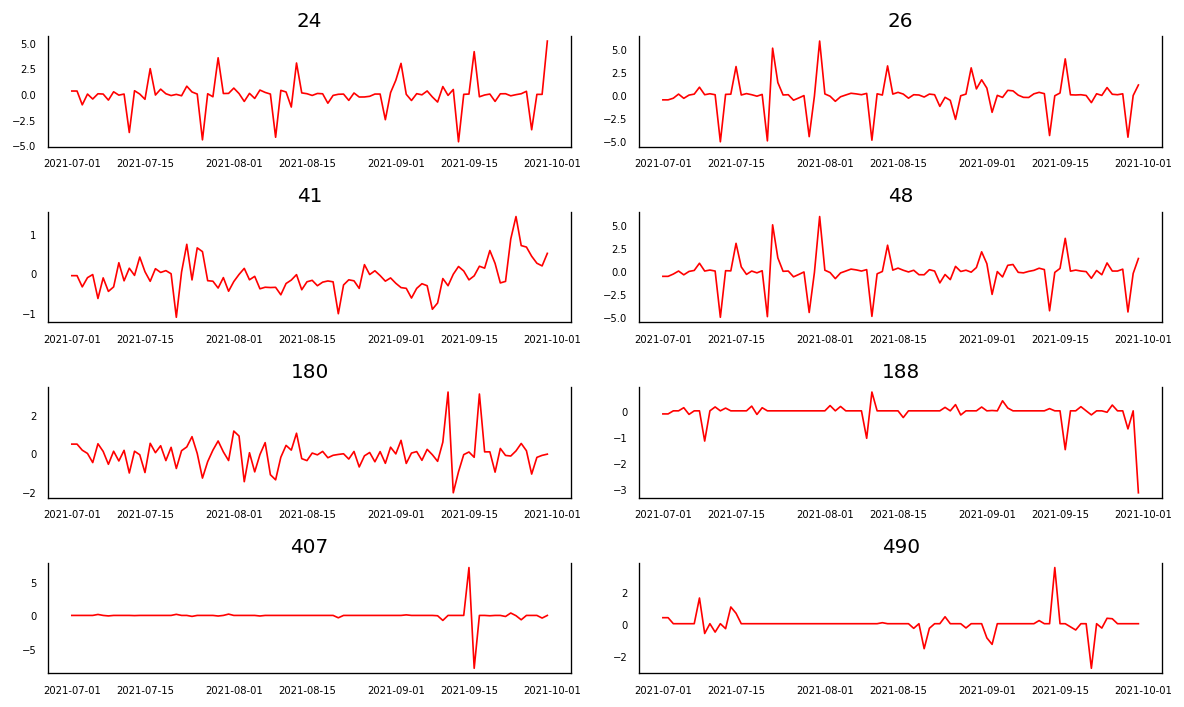

In [47]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot885[pivot885.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(pivot885.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [48]:
 
for name, column in pivot885.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.8218
 No. Lags Chosen       = 12
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.734
 No. Lags Chosen       = 9
 Critical value 1%     = -3.513
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Te

In [49]:
pivot885 = pivot885.diff().dropna()

In [50]:
 
for name, column in pivot885.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.1029
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.2717
 No. Lags Chosen       = 9
 Critical value 1%     = -3.514
 Critical value 5%     = -2.898
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [51]:
cointegration_test(pivot885)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  347.57    > 143.6691  =>   True
26     ::  268.43    > 111.7797  =>   True
41     ::  202.26    > 83.9383   =>   True
48     ::  148.64    > 60.0627   =>   True
180    ::  102.75    > 40.1749   =>   True
188    ::  64.55     > 24.2761   =>   True
407    ::  27.47     > 12.3212   =>   True
490    ::  10.3      > 4.1296    =>   True


In [52]:

#VAR model on df_pivot
model = VAR(pivot885)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,0.2667,0.4999,1.306,0.3604
1,-1.920,0.1779*,0.1476,-1.077
2,-2.655,1.309,0.07369,-1.063
3,-3.245,2.584,0.04548,-0.9032
4,-3.652,4.042,0.03760,-0.5609
5,-4.177,5.382,0.03272,-0.3369
6,-4.376,7.048,0.05127,0.2131
7,-6.010,7.279,0.02931,-0.6713
8,-10.10*,5.051,0.003094*,-4.015*


In [53]:

model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:08:35
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    2.12735
Nobs:                     88.0000    HQIC:                  -1.23465
Log likelihood:          -644.803    FPE:                  0.0342391
AIC:                     -3.50296    Det(Omega_mle):      0.00463186
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.047219         0.140253            0.337           0.736
L1.24         -0.585348         0.137239           -4.265           0.000
L1.26         -0.347408         0.234861           -1.479           0.139
L1.41         -1.

# PIVOT 2880

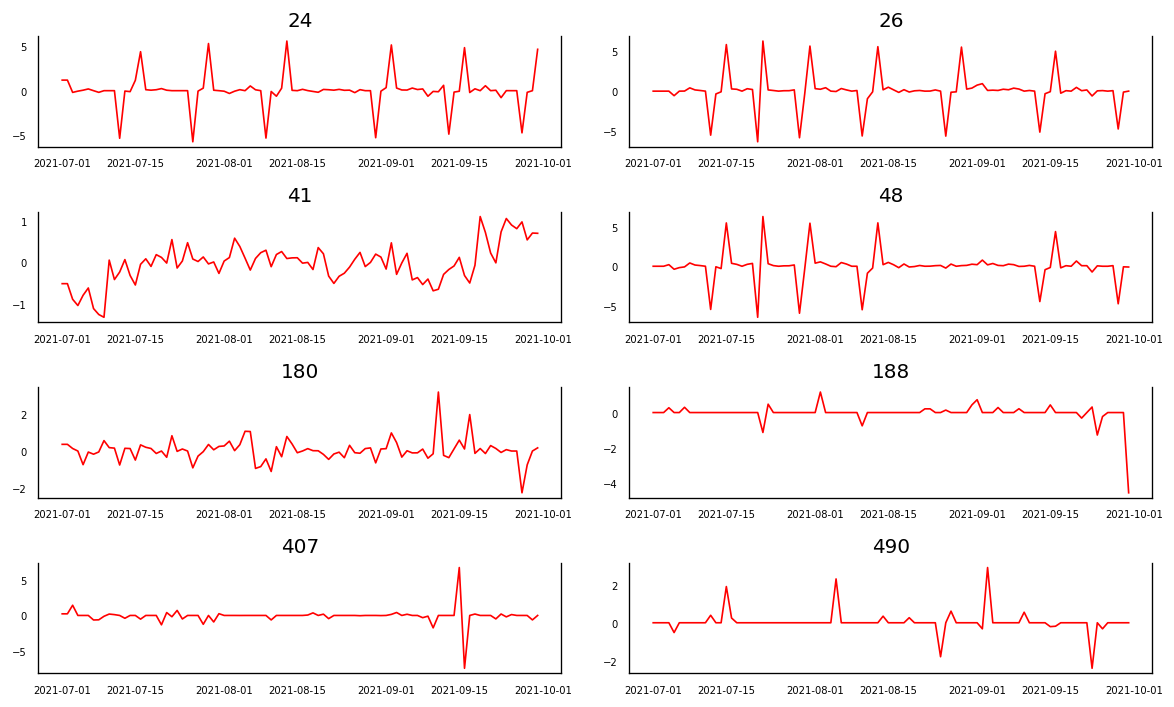

In [54]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot2880[pivot2880.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(pivot2880.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [55]:
    
for name, column in pivot2880.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.0085
 No. Lags Chosen       = 12
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.7675
 No. Lags Chosen       = 12
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 

In [56]:
pivot2880 = pivot2880.diff().dropna()

In [57]:
    
for name, column in pivot2880.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.9437
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.4322
 No. Lags Chosen       = 10
 Critical value 1%     = -3.515
 Critical value 5%     = -2.898
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Tes

In [58]:
cointegration_test(pivot2880)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  429.51    > 143.6691  =>   True
26     ::  316.04    > 111.7797  =>   True
41     ::  241.2     > 83.9383   =>   True
48     ::  172.95    > 60.0627   =>   True
180    ::  108.93    > 40.1749   =>   True
188    ::  61.54     > 24.2761   =>   True
407    ::  28.73     > 12.3212   =>   True
490    ::  11.32     > 4.1296    =>   True


In [59]:

#VAR model on df_pivot
model = VAR(pivot2880)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,1.852,2.085*,6.370,1.945
1,0.6636,2.762,1.955,1.507
2,0.5465,4.510,1.810,2.139
3,0.2587,6.087,1.511,2.600
4,-0.2060,7.488,1.179,2.885
5,-0.1672,9.392,1.804,3.673
6,-1.571,9.853,0.8480,3.019
7,-2.966,10.32,0.6152,2.372
8,-5.514*,9.640,0.3043*,0.5738*


In [60]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:08:42
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    9.63990
Nobs:                     83.0000    HQIC:                  0.573817
Log likelihood:          -193.332    FPE:                   0.304318
AIC:                     -5.51428    Det(Omega_mle):      0.00297755
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.061695         0.188149           -0.328           0.743
L1.24         -0.749809         0.221770           -3.381           0.001
L1.26         -0.634461         0.401933           -1.579           0.114
L1.41          2.

# PIVOT 1127

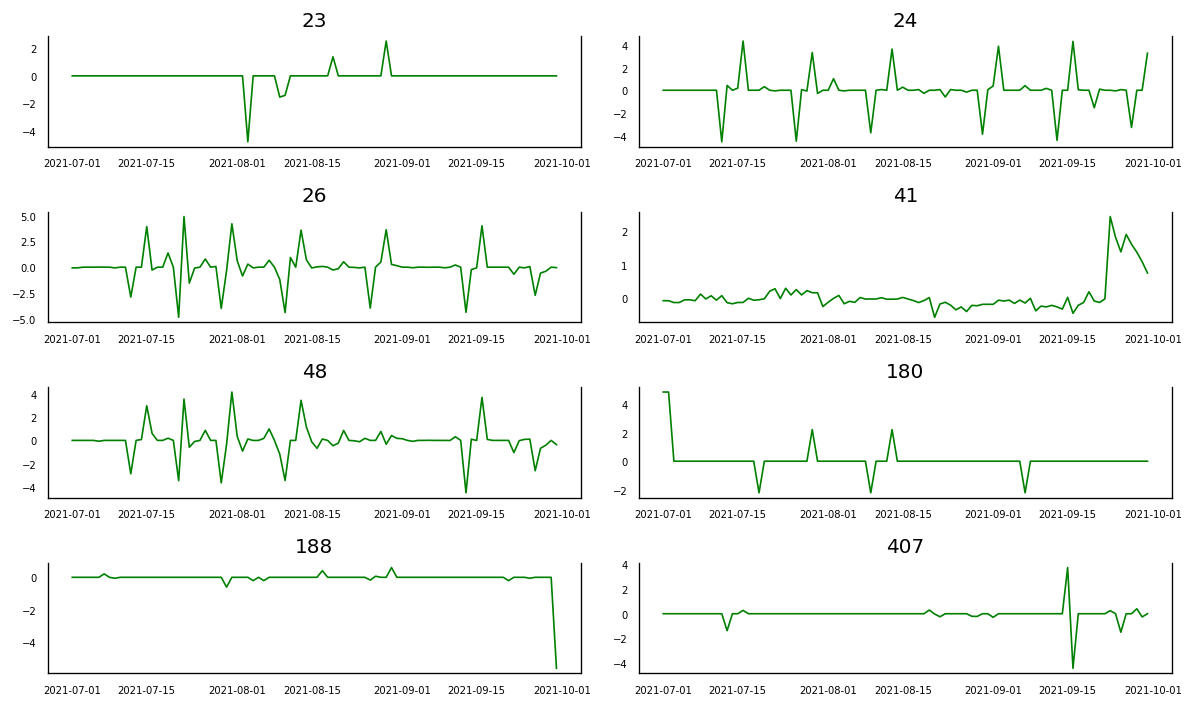

In [61]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1127[pivot1127.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1127.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [62]:
for name, column in pivot1127.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.911
 No. Lags Chosen       = 0
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.0842
 No. Lags Chosen       = 12
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [63]:
pivot1127 = pivot1127.diff().dropna()

In [64]:
for name, column in pivot1127.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.7555
 No. Lags Chosen       = 5
 Critical value 1%     = -3.51
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.8023
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [65]:
cointegration_test(pivot1127)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  443.39    > 179.5199  =>   True
24     ::  302.11    > 143.6691  =>   True
26     ::  235.86    > 111.7797  =>   True
41     ::  174.45    > 83.9383   =>   True
48     ::  123.14    > 60.0627   =>   True
180    ::  81.67     > 40.1749   =>   True
188    ::  48.84     > 24.2761   =>   True
407    ::  18.49     > 12.3212   =>   True
490    ::  2.27      > 4.1296    =>   False


In [66]:

#VAR model on df_pivot
model = VAR(pivot1127)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-1.858,-1.595,0.1561,-1.752
1,-2.583,0.03969,0.07634,-1.529
2,-2.678,2.306,0.07403,-0.6756
3,-2.648,4.695,0.09063,0.3019
4,-2.912,6.792,0.09959,0.9864
5,-3.041,9.025,0.1692,1.807
6,-3.764,10.66,0.2628,2.031
7,-9.820,6.966,0.005065,-3.076
8,-21.86*,-2.710*,2.345e-06*,-14.17*


In [67]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:08:49
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -2.71048
Nobs:                     83.0000    HQIC:                  -14.1651
Log likelihood:           504.127    FPE:                2.34532e-06
AIC:                     -21.8572    Det(Omega_mle):     8.01279e-09
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.006992         0.065087           -0.107           0.914
L1.23         -0.812177         0.259195           -3.133           0.002
L1.24         -0.030275         0.111444           -0.272           0.786
L1.26         -0.

# PIVOT 1354

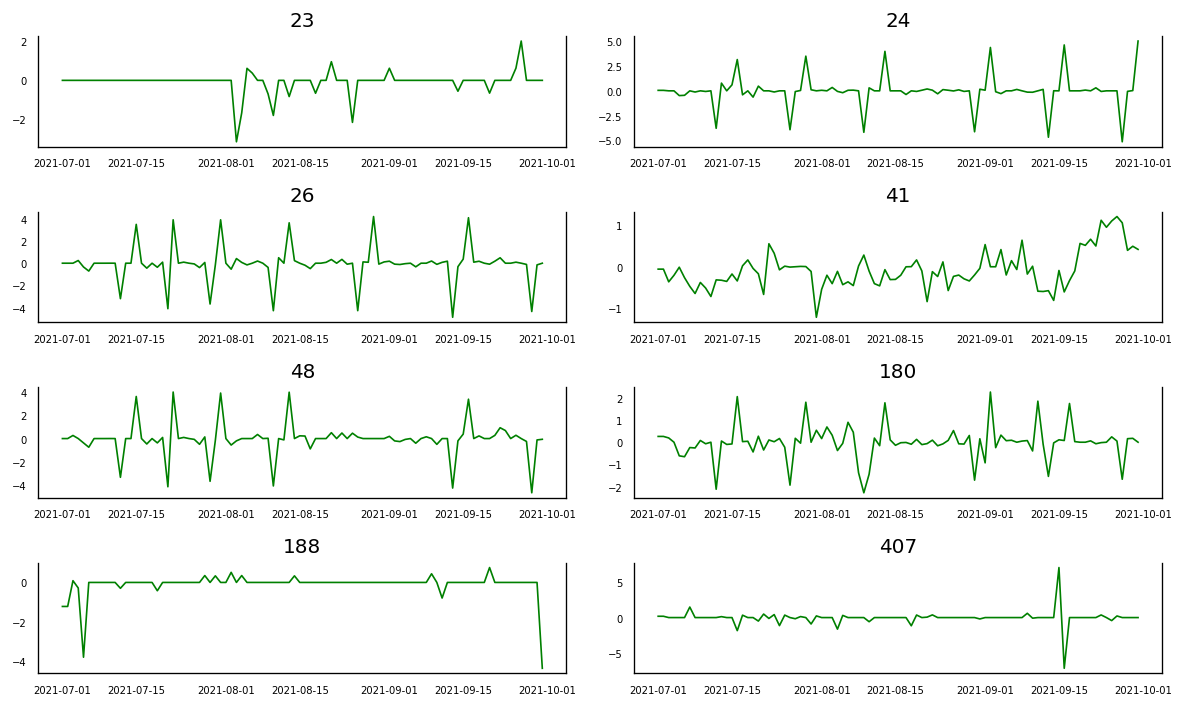

In [68]:

fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1354[pivot1354.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1354.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [69]:
  
for name, column in pivot1354.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.8741
 No. Lags Chosen       = 1
 Critical value 1%     = -3.505
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.8487
 No. Lags Chosen       = 12
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [70]:
pivot1354 = pivot1354.diff().dropna()

In [71]:
  
for name, column in pivot1354.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "23" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.954
 No. Lags Chosen       = 7
 Critical value 1%     = -3.512
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.3999
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [72]:
cointegration_test(pivot1354)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
23     ::  426.55    > 179.5199  =>   True
24     ::  309.44    > 143.6691  =>   True
26     ::  221.56    > 111.7797  =>   True
41     ::  165.15    > 83.9383   =>   True
48     ::  114.13    > 60.0627   =>   True
180    ::  79.9      > 40.1749   =>   True
188    ::  48.36     > 24.2761   =>   True
407    ::  24.02     > 12.3212   =>   True
490    ::  4.09      > 4.1296    =>   False


In [73]:

#VAR model on df_pivot
model = VAR(pivot1354)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,0.9428,1.205,2.567,1.048
1,-0.2530,2.370,0.7847,0.8007
2,-0.6579,4.325,0.5579,1.344
3,-1.207,6.137,0.3832,1.744
4,-1.409,8.295,0.4477,2.490
5,-2.243,9.822,0.3759,2.604
6,-3.366,11.06,0.3914,2.430
7,-8.947,7.839,0.01212,-2.203
8,-21.85*,-2.700*,2.370e-06*,-14.15*


In [74]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:08:55
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -2.70007
Nobs:                     83.0000    HQIC:                  -14.1547
Log likelihood:           503.695    FPE:                2.36986e-06
AIC:                     -21.8468    Det(Omega_mle):     8.09663e-09
--------------------------------------------------------------------
Results for equation 23
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.001817         0.053661           -0.034           0.973
L1.23         -0.457571         0.220512           -2.075           0.038
L1.24          0.370612         0.179038            2.070           0.038
L1.26          0.

# PIVOT 1617

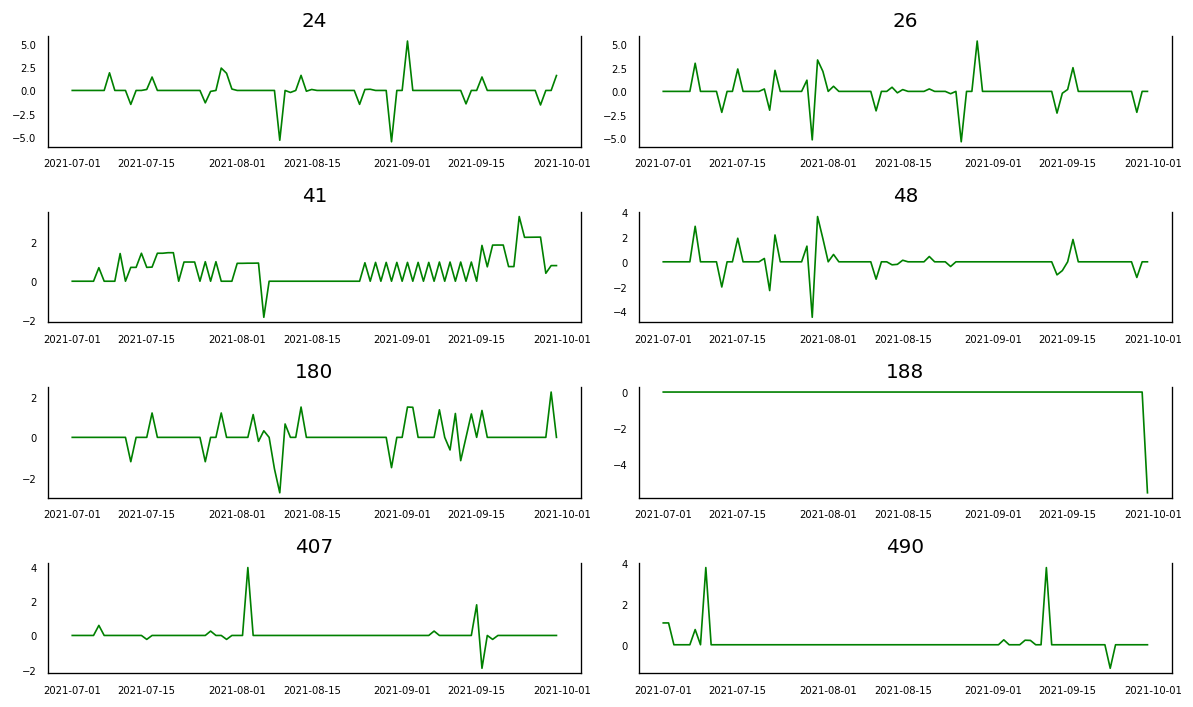

In [75]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1617[pivot1617.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1617.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [76]:
   
for name, column in pivot1617.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.1884
 No. Lags Chosen       = 2
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.4711
 No. Lags Chosen       = 2
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [77]:
pivot1617.drop(188,inplace=True,axis=1)

In [78]:
   
for name, column in pivot1617.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.1884
 No. Lags Chosen       = 2
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.4711
 No. Lags Chosen       = 2
 Critical value 1%     = -3.506
 Critical value 5%     = -2.895
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [79]:
cointegration_test(pivot1617)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  167.28    > 111.7797  =>   True
26     ::  106.74    > 83.9383   =>   True
41     ::  63.79     > 60.0627   =>   True
48     ::  39.35     > 40.1749   =>   False
180    ::  18.07     > 24.2761   =>   False
407    ::  6.32      > 12.3212   =>   False
490    ::  0.22      > 4.1296    =>   False


In [80]:

#VAR model on df_pivot
model = VAR(pivot1617)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-4.358,-4.155*,0.01281*,-4.276*
1,-4.176,-2.555,0.01542,-3.525
2,-3.602,-0.5630,0.02803,-2.380
3,-3.538,0.9182,0.03172,-1.747
4,-4.327,1.548,0.01625,-1.965
5,-4.175,3.117,0.02326,-1.244
6,-4.450,4.261,0.02468,-0.9480
7,-5.017,5.112,0.02353,-0.9451
8,-6.378*,5.168,0.01347,-1.737


In [81]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:09:00
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    5.16826
Nobs:                     84.0000    HQIC:                  -1.73657
Log likelihood:          -167.455    FPE:                  0.0134650
AIC:                     -6.37812    Det(Omega_mle):     0.000358614
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.071912         0.158818            0.453           0.651
L1.24         -0.008536         0.206381           -0.041           0.967
L1.26         -0.140511         0.128379           -1.095           0.274
L1.41          0.

# PIVOT 1776

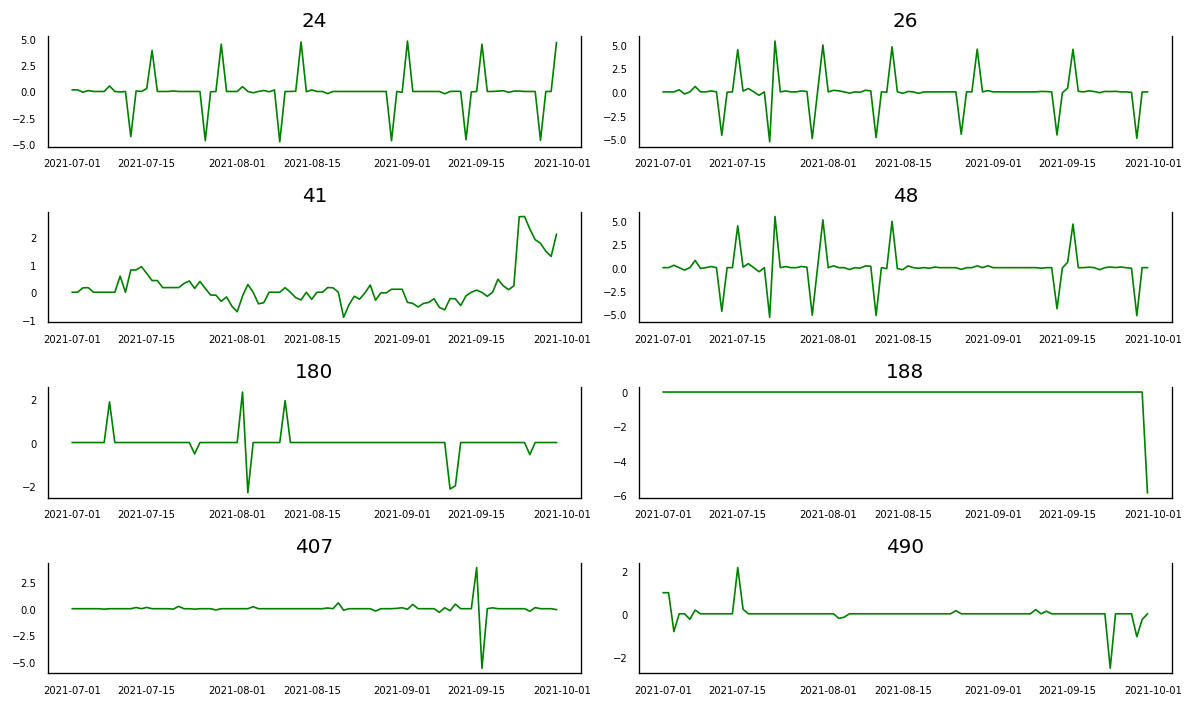

In [82]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot1776[pivot1776.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot1776.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [83]:
pivot1776.drop(188,inplace=True,axis=1)

In [84]:
for name, column in pivot1776.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.043
 No. Lags Chosen       = 12
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.8374
 No. Lags Chosen       = 12
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test

In [85]:
cointegration_test(pivot1776)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  182.47    > 111.7797  =>   True
26     ::  124.55    > 83.9383   =>   True
41     ::  84.14     > 60.0627   =>   True
48     ::  49.97     > 40.1749   =>   True
180    ::  22.8      > 24.2761   =>   False
407    ::  9.45      > 12.3212   =>   False
490    ::  0.01      > 4.1296    =>   False


In [86]:

#VAR model on df_pivot
model = VAR(pivot1776)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-3.196,-2.994*,0.04092,-3.115
1,-3.960,-2.340,0.01913*,-3.309*
2,-3.273,-0.2347,0.03892,-2.052
3,-3.129,1.327,0.04774,-1.338
4,-2.999,2.875,0.06128,-0.6379
5,-2.214,5.078,0.1653,0.7173
6,-1.954,6.757,0.2994,1.548
7,-3.456,6.672,0.1120,0.6154
8,-4.472*,7.074,0.09055,0.1692


In [87]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:09:08
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    7.07405
Nobs:                     84.0000    HQIC:                  0.169221
Log likelihood:          -247.498    FPE:                  0.0905489
AIC:                     -4.47233    Det(Omega_mle):      0.00241160
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const         -0.007182         0.166321           -0.043           0.966
L1.24          0.074635         0.186120            0.401           0.688
L1.26         -0.289190         0.319942           -0.904           0.366
L1.41         -0.

# PIVOT 624

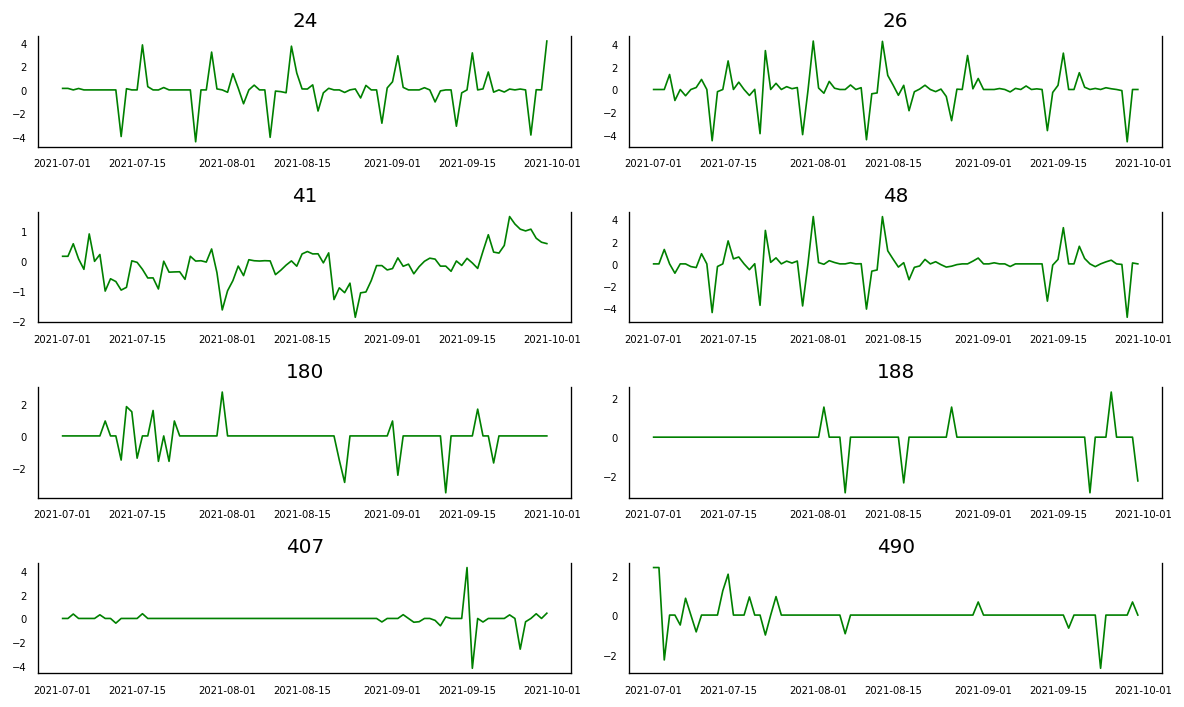

In [88]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = pivot624[pivot624.columns[i]]
    ax.plot(data, color='green', linewidth=1)
    # Decorations
    ax.set_title(pivot624.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [89]:
 
for name, column in pivot624.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.9736
 No. Lags Chosen       = 12
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.7162
 No. Lags Chosen       = 12
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 

In [90]:
pivot624 = pivot624.diff().dropna()

In [91]:
 
for name, column in pivot624.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "24" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.8334
 No. Lags Chosen       = 12
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "26" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.1
 No. Lags Chosen       = 7
 Critical value 1%     = -3.512
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "41" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test St

In [92]:
cointegration_test(pivot624)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
24     ::  494.27    > 143.6691  =>   True
26     ::  358.59    > 111.7797  =>   True
41     ::  266.53    > 83.9383   =>   True
48     ::  199.88    > 60.0627   =>   True
180    ::  138.26    > 40.1749   =>   True
188    ::  90.17     > 24.2761   =>   True
407    ::  51.26     > 12.3212   =>   True
490    ::  21.39     > 4.1296    =>   True


In [93]:

#VAR model on df_pivot
model = VAR(pivot624)
x = model.select_order(maxlags=8)
x.summary()


c:\Users\cosim\anaconda3\envs\bigdata\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-0.3083,-0.07518*,0.7347,-0.2147
1,-1.451,0.6474,0.2360,-0.6079
2,-1.606,2.358,0.2104,-0.01354
3,-1.892,3.937,0.1759,0.4497
4,-2.101,5.592,0.1772,0.9896
5,-2.453,7.106,0.1835,1.387
6,-4.037,7.387,0.07199,0.5525
7,-6.343,6.947,0.02102,-1.004
8,-9.824*,5.330,0.004089*,-3.736*


In [94]:

model_fitted = model.fit(8)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Dec, 2022
Time:                     22:09:14
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    5.33013
Nobs:                     83.0000    HQIC:                  -3.73595
Log likelihood:          -14.4771    FPE:                 0.00408904
AIC:                     -9.82405    Det(Omega_mle):     4.00085e-05
--------------------------------------------------------------------
Results for equation 24
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.029270         0.154677            0.189           0.850
L1.24         -0.666927         0.225972           -2.951           0.003
L1.26         -0.359086         0.928230           -0.387           0.699
L1.41          0.

# Grangers causation coded_cat1

In [95]:
from statsmodels.tsa.stattools import grangercausalitytests

Function build to have the grangers matrix

In [96]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=4
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
        df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
        for c in df.columns:
            for r in df.index:
                test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
                p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
                if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
                min_p_value = np.min(p_values)
                df.loc[r, c] = min_p_value
        df.columns = [var for var in variables]
        df.index = [var  for var in variables]
        return df

In [97]:
grangers_causation_matrix(pivot2180, variables = pivot2180.columns)

,24,26,41,48,180,188,407,490
24,1.0000,0.0222,0.3867,0.0101,0.0027,0.3292,0.0697,0.3123
26,0.1105,1.0000,0.5946,0.7378,0.3660,0.0904,0.3196,0.2642
41,0.4634,0.0485,1.0000,0.0234,0.5651,0.1225,0.0743,0.0160
48,0.0278,0.8743,0.4476,1.0000,0.1624,0.5666,0.1177,0.3350
180,0.0000,0.0283,0.8349,0.0000,1.0000,0.2909,0.0810,0.5693
188,0.8413,0.0260,0.4614,0.0177,0.5398,1.0000,0.9423,0.3744
407,0.0467,0.0055,0.7651,0.0012,0.0162,0.8400,1.0000,0.8806
490,0.5199,0.0006,0.0043,0.0005,0.4465,0.4953,0.9356,1.0000


compute the grangers causalty test for each of the category

In [98]:
for i in pdthird.coded_cat1.unique():
    globals()['grangers{}'.format(i)] = grangers_causation_matrix(globals()['pivot{}'.format(i)], variables = globals()['pivot{}'.format(i)].columns)

Based on the grangers causation:

In [99]:

print('Accordingly with the grangers causalty test:')

for j in pdthird.coded_cat1.unique():
    print(f'\n In the category {j}')
    for i in globals()['grangers{}'.format(j)].columns:
        if len(globals()['grangers{}'.format(j)][globals()['grangers{}'.format(j)][i] <= 0.05][i].index.values) > 0:
            print(f'Seller {i} is the leader and', globals()['grangers{}'.format(j)][globals()['grangers{}'.format(j)][i] <= 0.05][i].index.values ,'followers')
        else:
            print(f'Seller {i} has no follower')


Accordingly with the grangers causalty test:

 In the category 1163
Seller 23 is the leader and [26] followers
Seller 24 is the leader and [ 48 188 407] followers
Seller 26 has no follower
Seller 41 is the leader and [ 24 407] followers
Seller 48 is the leader and [ 24 180 407] followers
Seller 180 is the leader and [ 24 407] followers
Seller 188 is the leader and [ 23  41 490] followers
Seller 407 is the leader and [ 24 188] followers
Seller 490 is the leader and [23] followers

 In the category 1354
Seller 23 is the leader and [180] followers
Seller 24 is the leader and [ 48 407 490] followers
Seller 26 is the leader and [407] followers
Seller 41 is the leader and [23] followers
Seller 48 is the leader and [407 490] followers
Seller 180 is the leader and [ 48 407 490] followers
Seller 188 has no follower
Seller 407 is the leader and [ 24 180] followers
Seller 490 is the leader and [180] followers

 In the category 1127
Seller 23 has no follower
Seller 24 is the leader and [407] follo

Insert the results into a DataFrame: the dataframe show the followers of each seller (leader), on columns, for each category

In [100]:
leader = {}
for j in pdthird.coded_cat1.unique():
    follower = {}
    for i in globals()['grangers{}'.format(j)].columns:
        if len(globals()['grangers{}'.format(j)][globals()['grangers{}'.format(j)][i] <= 0.05][i].index.values) > 0:
            follower[i] = list(globals()['grangers{}'.format(j)][globals()['grangers{}'.format(j)][i] <= 0.05][i].index.values)
    leader[j] = follower           

matrix = pd.DataFrame(leader).T
matrix

,23,24,41,48,180,188,407,490,26
1163,[26],"[48, 188, 407]","[24, 407]","[24, 180, 407]","[24, 407]","[23, 41, 490]","[24, 188]",[23],NaN
1354,[180],"[48, 407, 490]",[23],"[407, 490]","[48, 407, 490]",NaN,"[24, 180]",[180],[407]
1127,NaN,[407],NaN,"[23, 24, 407]","[26, 48]",[23],[48],NaN,"[23, 407]"
1375,NaN,"[23, 48, 407]",[24],[407],"[407, 490]",NaN,[180],NaN,[407]
885,NaN,"[48, 180, 188, 407]","[24, 180]","[180, 188, 407]","[24, 188, 407, 490]","[24, 180, 407]","[180, 188, 490]","[188, 407]","[180, 188, 407]"
2880,NaN,"[48, 180, 188, 407]",[490],"[41, 407]","[41, 188, 407]",NaN,[180],NaN,"[41, 407]"
1676,NaN,"[48, 188]",[188],"[180, 407]","[26, 48, 188, 407]",[180],[180],[41],"[180, 407]"
2259,NaN,"[48, 188, 407]","[188, 490]","[180, 407]","[26, 48, 407]",NaN,"[48, 180]","[26, 41, 188]",[407]
2180,NaN,"[48, 180, 407]",[490],"[24, 41, 180, 188, 407, 490]","[24, 407]",NaN,NaN,[41],"[24, 41, 180, 188, 407, 490]"
1776,NaN,"[26, 48, 407]",[490],[407],[24],NaN,NaN,NaN,[407]


computing the more recurrent follower for each seller, and counting in how many categories is the follower

In [101]:
matrix0 = matrix.fillna(0)
follower_mode = []
for i in matrix0.columns:
    mode=[]
    for j in matrix0.index:
        if matrix0[i][j] != 0:
            for g in range(len(matrix0[i][j])):
                mode.append(matrix0[i][j][g])
    print(f'The more recurrent follower for seller {i} is {max(set(mode), key=mode.count)}, that is a follower in {mode.count(max(set(mode), key=mode.count))} categories')
    follower_mode.append(max(set(mode), key=mode.count))

The more recurrent follower for seller 23 is 26, that is a follower in 1 categories
The more recurrent follower for seller 24 is 48, that is a follower in 11 categories
The more recurrent follower for seller 41 is 490, that is a follower in 4 categories
The more recurrent follower for seller 48 is 407, that is a follower in 12 categories
The more recurrent follower for seller 180 is 407, that is a follower in 9 categories
The more recurrent follower for seller 188 is 490, that is a follower in 2 categories
The more recurrent follower for seller 407 is 180, that is a follower in 7 categories
The more recurrent follower for seller 490 is 41, that is a follower in 3 categories
The more recurrent follower for seller 26 is 407, that is a follower in 11 categories


In [103]:
matrix2 = matrix.append(pd.Series(follower_mode, index=matrix.columns, name='followers mode'))

Adding the percentage of the time a seller is leader and the more reccurrent follower to the dataframe

In [104]:
matrix2

,23,24,41,48,180,188,407,490,26
1163,[26],"[48, 188, 407]","[24, 407]","[24, 180, 407]","[24, 407]","[23, 41, 490]","[24, 188]",[23],NaN
1354,[180],"[48, 407, 490]",[23],"[407, 490]","[48, 407, 490]",NaN,"[24, 180]",[180],[407]
1127,NaN,[407],NaN,"[23, 24, 407]","[26, 48]",[23],[48],NaN,"[23, 407]"
1375,NaN,"[23, 48, 407]",[24],[407],"[407, 490]",NaN,[180],NaN,[407]
885,NaN,"[48, 180, 188, 407]","[24, 180]","[180, 188, 407]","[24, 188, 407, 490]","[24, 180, 407]","[180, 188, 490]","[188, 407]","[180, 188, 407]"
2880,NaN,"[48, 180, 188, 407]",[490],"[41, 407]","[41, 188, 407]",NaN,[180],NaN,"[41, 407]"
1676,NaN,"[48, 188]",[188],"[180, 407]","[26, 48, 188, 407]",[180],[180],[41],"[180, 407]"
2259,NaN,"[48, 188, 407]","[188, 490]","[180, 407]","[26, 48, 407]",NaN,"[48, 180]","[26, 41, 188]",[407]
2180,NaN,"[48, 180, 407]",[490],"[24, 41, 180, 188, 407, 490]","[24, 407]",NaN,NaN,[41],"[24, 41, 180, 188, 407, 490]"
1776,NaN,"[26, 48, 407]",[490],[407],[24],NaN,NaN,NaN,[407]


# Plot

Sorting the product based on the number of time the price was changed for that product

In [105]:
pdthird0 = pdthird.fillna(0)
pdthird0['price_change_sign'] = np.where(pdthird.price_change == 0, 1, 0)
prod_p_var = pdthird0.groupby(['product_id','coded_cat1'])['price_change_sign'].sum()
prod_p_var = pd.DataFrame(prod_p_var)
prod_p_var.reset_index(inplace=True)
prod_p_var.sort_values('price_change_sign', ascending=False, inplace=True)

In [106]:
prod_p_var[prod_p_var.coded_cat1 == 1163].head(20)

,product_id,coded_cat1,price_change_sign
3932,159243,1163,612
733,121818,1163,574
2013,141764,1163,561
551,110362,1163,557
3514,156666,1163,532
3450,156388,1163,519
849,124506,1163,519
747,121953,1163,513
2712,149314,1163,509
609,111861,1163,490


<AxesSubplot: xlabel='comp_date', ylabel='price'>

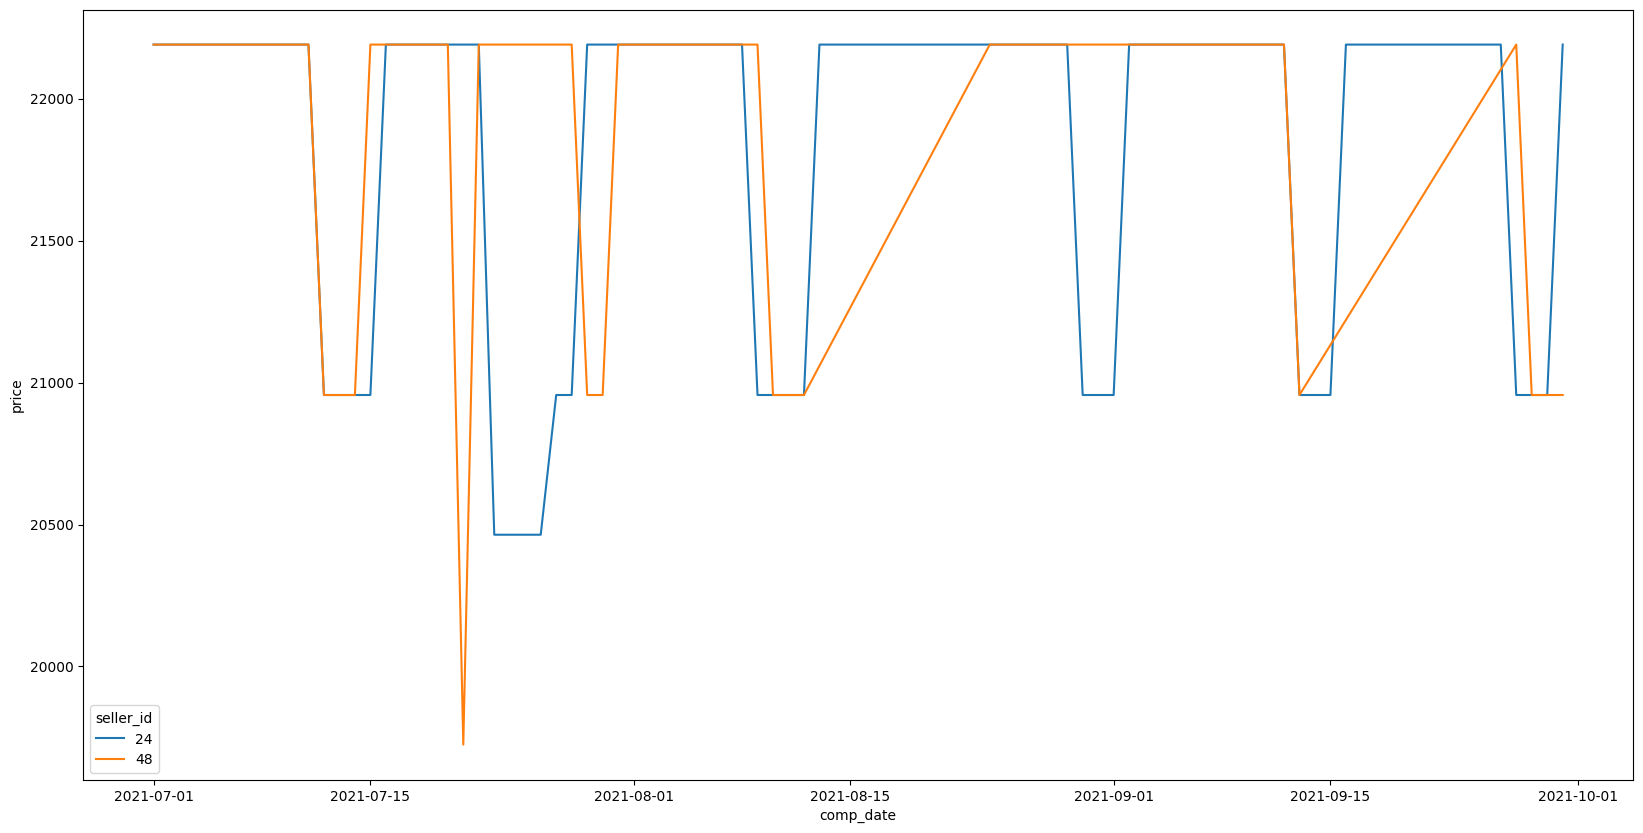

In [107]:
pdthird['comp_date'] = pd.to_datetime(pdthird['comp_date'])
plt.figure(figsize=(20,10))
df = pdthird[(pdthird.product_id == 143123) & (pdthird.seller_id.isin([24,48]))]
sns.lineplot(data = df, x = 'comp_date', y='price', hue='seller_id', palette=sns.color_palette("tab10"))
#sns.lineplot(data = df, x = 'comp_date', y = 'max(price)', c = 'r')
#sns.lineplot(data = df, x = 'comp_date', y = 'min(price)', c = 'r')

<AxesSubplot: xlabel='comp_date', ylabel='price'>

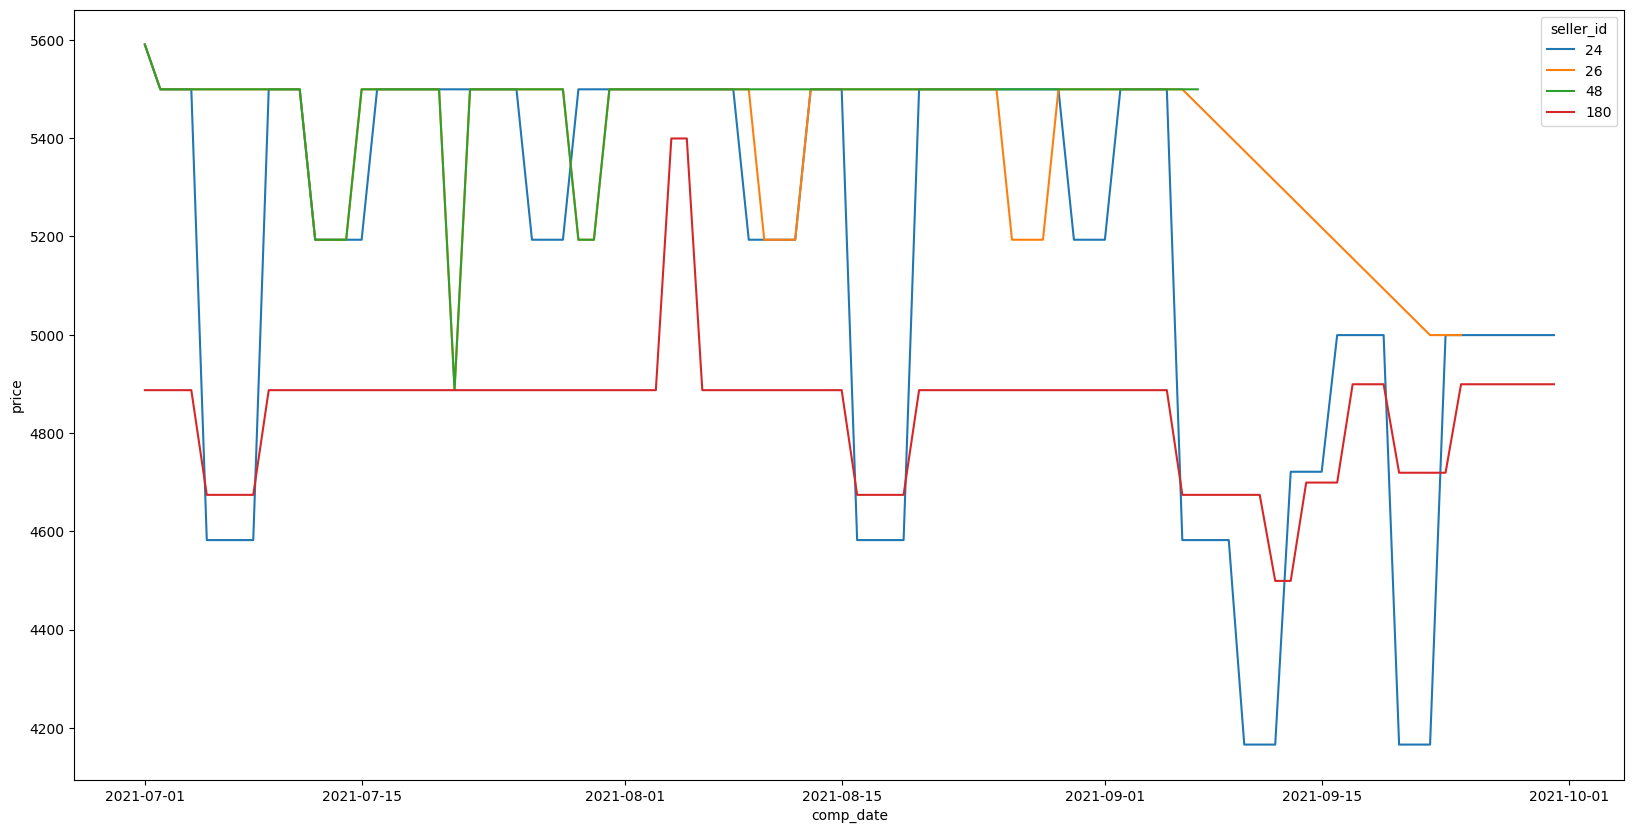

In [108]:
pdthird['comp_date'] = pd.to_datetime(pdthird['comp_date'])
plt.figure(figsize=(20,10))
df = pdthird[(pdthird.product_id == 143546) & (pdthird.seller_id.isin([24, 26, 48, 180]))]
sns.lineplot(data = df, x = 'comp_date', y='price', hue='seller_id', palette=sns.color_palette("tab10"))
#sns.lineplot(data = df, x = 'comp_date', y = 'max(price)', c = 'r')
#sns.lineplot(data = df, x = 'comp_date', y = 'min(price)', c = 'r')